This notebook documents calculations related to far-field light scattered by a sphere.

In [1]:
# Run this line if haven't installed the `miepython` package
# !pip install --user miepython

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import miepython

import importlib.resources

In [3]:
import scipy.signal

In [3]:
# Import the refractive index data for fused silica
# We will use m = 1.45
sio2 = np.genfromtxt('https://refractiveindex.info/tmp/data/main/SiO2/Malitson.txt', delimiter='\t')

N = len(sio2)
sio2_lam = sio2[1:N, 0]  # wavelength in microns
sio2_mre = sio2[1:N, 1]

In [95]:
# Will use m = 1.768 for sapphire
sapphire = np.genfromtxt('https://refractiveindex.info/tmp/data/main/Al2O3/Malitson-o.txt', delimiter='\t')

N = len(sapphire)
sapphire_lam = sapphire[1:N, 0]  # wavelength in microns
sapphire_mre = sapphire[1:N, 1]

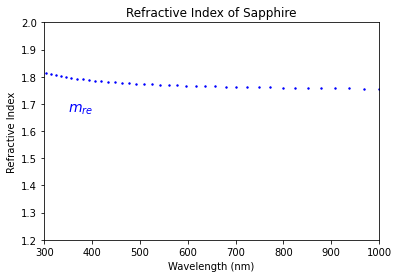

In [99]:
plt.figure(figsize=(6, 4))
plt.scatter(sapphire_lam*1000, sapphire_mre, s=2, color='blue')
plt.xlim(300, 1000)
plt.ylim(1.2, 2)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Refractive Index')
plt.text(350, 1.67, '$m_{re}$', color='blue', fontsize=14)

plt.title('Refractive Index of Sapphire')
plt.show()

## Scattering function

The scattering function $p(\theta)$ described the amount of light scatterd by a particle for a plane wave incident in the $z$-direction. There is no $\phi$ dependence because of rotational symmetry. The angle is often replaced by $\mu = \cos \theta$.

We will mostly use the function `miepython.i_unpolarized` below. This function returns the unpolarized scattered intensity at an angle. Actually, this is the average of the intensity of scattering matrix elements $S_1^2$ and $S_2^2$, which are proportional to the power from E field components parallel and perpendicular to the scattering plane.

`miepython` normalizes the scattering function so that the integral over solid angle will be a single scattering albedo. This affects the absolute value of the scattered intensity. See https://miepython.readthedocs.io/en/latest/03a_normalization.html

In [3]:
def plot_scattered_angular(m, lam, r):
    x = 2 * np.pi * r / lam

    theta = np.linspace(-180,180,180)
    mu = np.cos(theta/180*np.pi)
    scat = miepython.i_unpolarized(m, x, mu)

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    ax0 = plt.subplot(121, projection='polar')
    ax0.plot(theta/180*np.pi, scat)
    ax0.set_title(f'm=1.45, diameter={r*2:.2f} $\mu$m, $\lambda$=780 nm')

    ax1 = plt.subplot(122)
    ax1.plot(theta,scat)
    ax1.set_xlabel('Scattering angle ($\degree$)')
    ax1.set_ylabel('Total scattered light (1/sr)')
    ax1.set_title(f'm=1.45, diameter={r*2:.2f} $\mu$m, $\lambda$=780 nm')

    return (ax0, ax1)

We can calculate the angular distribution of the scattered intensity. When the sphere is comparable to the wavelength, we have a significant amount of scattered spherical waves.

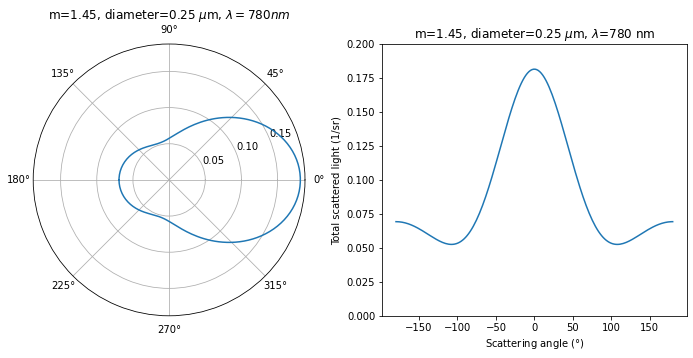

In [112]:
m, lam = 1.45, 0.78
r = 0.125
ax0, ax1 = plot_scattered_angular(m, lam, r)
ax0.set_rticks([0.05, 0.1, 0.15])
ax1.set_ylim(0.00,0.2)
plt.show()

This the case of a large sphere, most of the power is in the forward-scattered light.

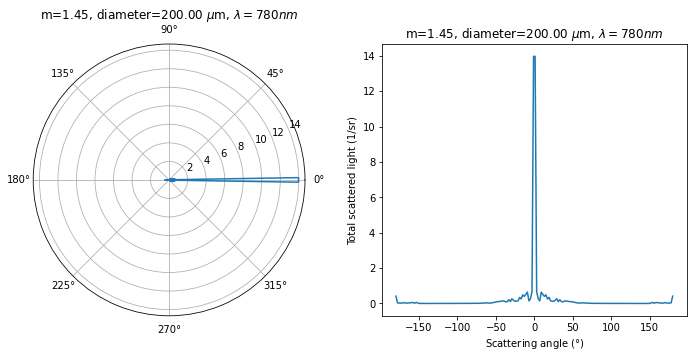

In [44]:
m, lam = 1.45, 0.78
r = 100
ax0, ax1 = plot_scattered_angular(m, lam, r)

## Spectrum of the scattered light

In [4]:
def scattered_spectrum(m, lam, r):
    """Spectrum of light scattered at 0, 90, and 180 degree"""
    x = 2 * np.pi * r / lam

    theta = np.array([0, 90, 180])
    mu = np.cos(theta/180 * np.pi)

    scattered = np.empty(shape=(np.size(lam), 3), dtype=np.float64)
    for i, lamb in enumerate(lam):
        scattered[i] = miepython.i_unpolarized(m, x[i], mu)
        
    return scattered.transpose()

We can calculate the scattered intensity at some angle as a function of frequency. The resonance structure basically comes from the whispering gallery mode excited at the frequencies.

Forward scattering ($\theta = 0^\circ$), $90^\circ$-scattering, and backward scattering ($\theta = 180^\circ$) for a diameter $10 \mu m$ sphere.

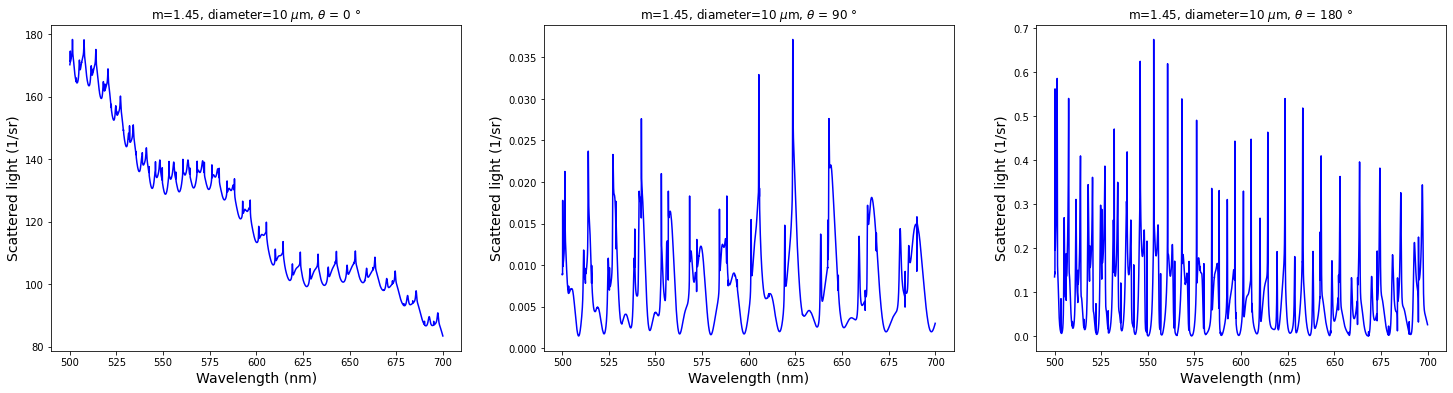

In [8]:
r = 5  # radius in microns
m = 1.45
lam = np.linspace(0.5, 0.7, 4000)

scattered = scattered_spectrum(m, lam, r)

fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for i, ax in enumerate(axes):
    ax.plot(lam*1000, scattered[i], 'b')
    ax.set_xlabel('Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 0 $\degree$')
axes[1].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$')
axes[2].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 180 $\degree$')
plt.show()

Repeat for a $50 \mu m$ and a $200 \mu m$ sphere. The peaks are getting closer to each other when the sphere size increases because there are more resonant modes in a larger sphere. Note that the $x$-scale is different for the $200 \mu m$ case.

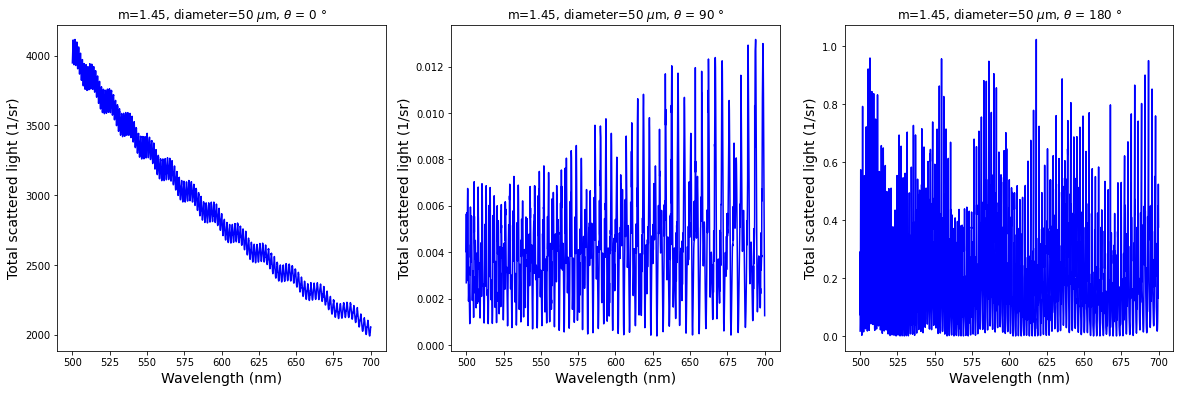

In [131]:
r = 25  # radius in microns
m = 1.45
lam = np.linspace(0.5, 0.7, 4000)

scattered = scattered_spectrum(m, lam, r)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, ax in enumerate(axes):
    ax.plot(lam*1000, scattered[i], 'b')
    ax.set_xlabel('Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Total scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 0 $\degree$')
axes[1].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$')
axes[2].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 180 $\degree$')
plt.show()

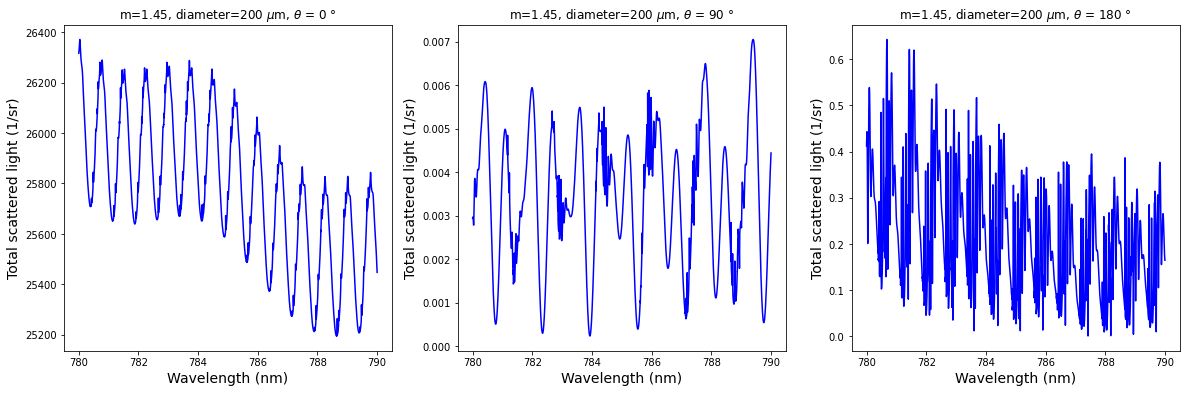

In [6]:
r = 100  # radius in microns
m = 1.45
lam = np.linspace(0.78, 0.79, 4000)

scattered = scattered_spectrum(m, lam, r)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, ax in enumerate(axes):
    ax.plot(lam*1000, scattered[i], 'b')
    ax.set_xlabel('Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Total scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 0 $\degree$')
axes[1].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$')
axes[2].set_title(fr'm=1.45, diameter={r*2:.0f} $\mu$m, $\theta$ = 180 $\degree$')
plt.show()

The case for a 300 $\mu m$ sapphire sphere:

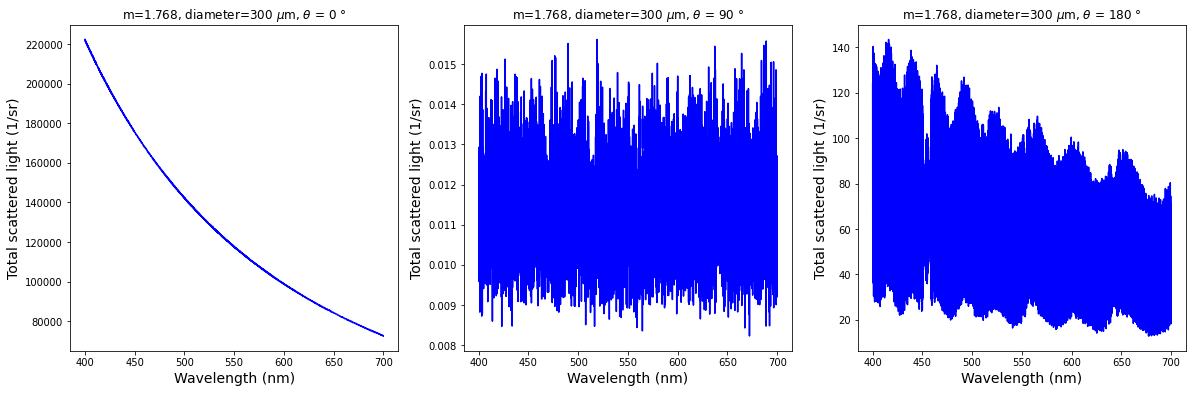

In [10]:
r = 150  # radius in microns
m = 1.768
lam = np.linspace(0.4, 0.7, 4000)

scattered = scattered_spectrum(m, lam, r)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, ax in enumerate(axes):
    ax.plot(lam*1000, scattered[i], 'b')
    ax.set_xlabel('Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Total scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm={m}, diameter={r*2:.0f} $\mu$m, $\theta$ = 0 $\degree$')
axes[1].set_title(fr'm={m}, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$')
axes[2].set_title(fr'm={m}, diameter={r*2:.0f} $\mu$m, $\theta$ = 180 $\degree$')
plt.show()

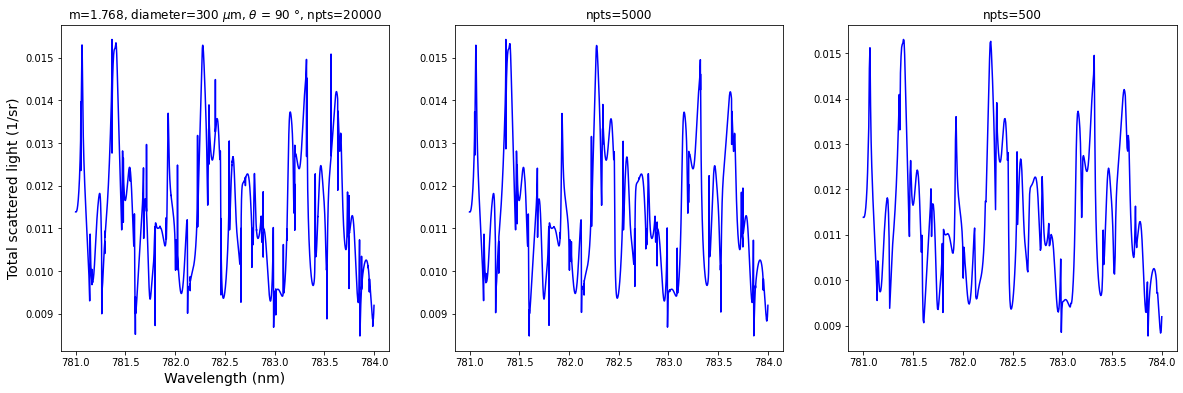

In [13]:
r = 150  # radius in microns
m = 1.768
lam = np.linspace(0.781, 0.784, 20000)
lam1 = np.linspace(0.781, 0.784, 5000)
lam2 = np.linspace(0.781, 0.784, 500)

scattered = scattered_spectrum(m, lam, r)
scattered1 = scattered_spectrum(m, lam1, r)
scattered2 = scattered_spectrum(m, lam2, r)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(lam*1000, scattered[1], 'b')
axes[1].plot(lam1*1000, scattered1[1], 'b')
axes[2].plot(lam2*1000, scattered2[1], 'b')

axes[0].set_xlabel('Wavelength (nm)', fontsize=14)
axes[0].set_ylabel('Total scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm={m}, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$, npts=20000')
axes[1].set_title('npts=5000')
axes[2].set_title('npts=500')

plt.show()

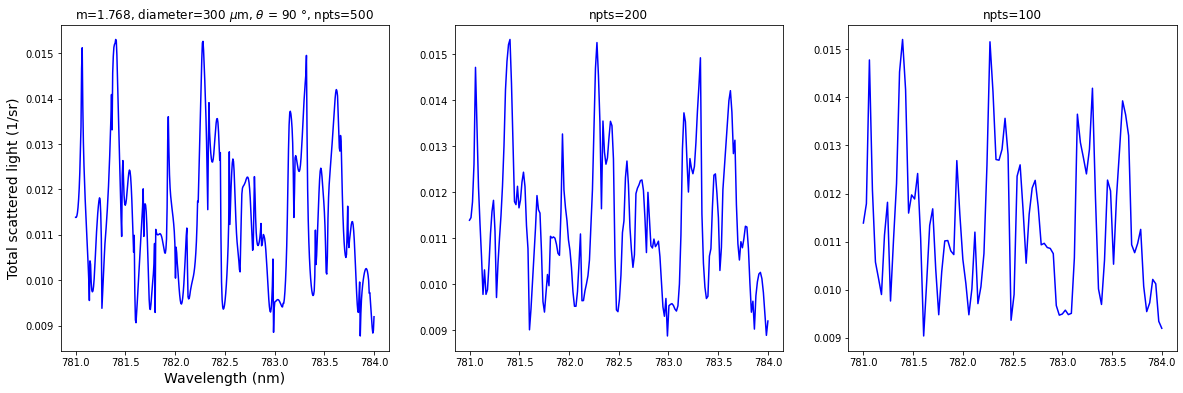

In [14]:
r = 150  # radius in microns
m = 1.768
lam = np.linspace(0.781, 0.784, 500)
lam1 = np.linspace(0.781, 0.784, 200)
lam2 = np.linspace(0.781, 0.784, 100)

scattered = scattered_spectrum(m, lam, r)
scattered1 = scattered_spectrum(m, lam1, r)
scattered2 = scattered_spectrum(m, lam2, r)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].plot(lam*1000, scattered[1], 'b')
axes[1].plot(lam1*1000, scattered1[1], 'b')
axes[2].plot(lam2*1000, scattered2[1], 'b')

axes[0].set_xlabel('Wavelength (nm)', fontsize=14)
axes[0].set_ylabel('Total scattered light (1/sr)', fontsize=14)
    
axes[0].set_title(fr'm={m}, diameter={r*2:.0f} $\mu$m, $\theta$ = 90 $\degree$, npts=500')
axes[1].set_title('npts=200')
axes[2].set_title('npts=100')

plt.show()

## Frequency spacing between resonances

In [103]:
def scattered_spectrum_ang(m, lam, r, theta):
    "Spectrum of light scattered at an angle in degree"
    x = 2 * np.pi * r / lam
    mu = np.cos(theta/180 * np.pi)

    scattered = np.empty(shape=(np.size(lam)), dtype=np.float64)
    for i, lamb in enumerate(lam):
        scattered[i] = miepython.i_unpolarized(m, x[i], mu)
        
    return scattered

def peak_spacing(lam, spec):
    """Average spacing between peaks found in the spectrum"""
    prom = 0.3 * (spec.max() - spec.min())
    peaks = scipy.signal.find_peaks(spec, prominence=prom)
    return np.average(np.diff(lam[peaks[0]]))

In [120]:
rad = np.linspace(5, 250, 100)
lam = np.linspace(0.5, 0.55, 4000)

In [121]:
spec_range = np.empty_like(rad, dtype=np.float64)
for i, r in enumerate(rad):
    spec = scattered_spectrum_ang(1.45, lam, r, 90)
    spec_range[i] = peak_spacing(lam, spec)

In [122]:
spec_range_180 = np.empty_like(rad, dtype=np.float64)
for i, r in enumerate(rad):
    spec = scattered_spectrum_ang(1.45, lam, r, 180)
    spec_range_180[i] = peak_spacing(lam, spec)

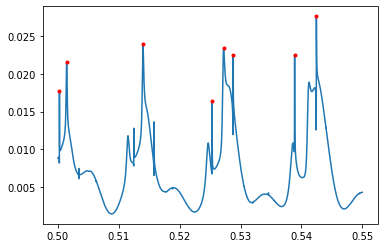

In [72]:
plt.plot(lam, spec)
plt.plot(lam[peaks[0]], spec[peaks[0]], '.r')

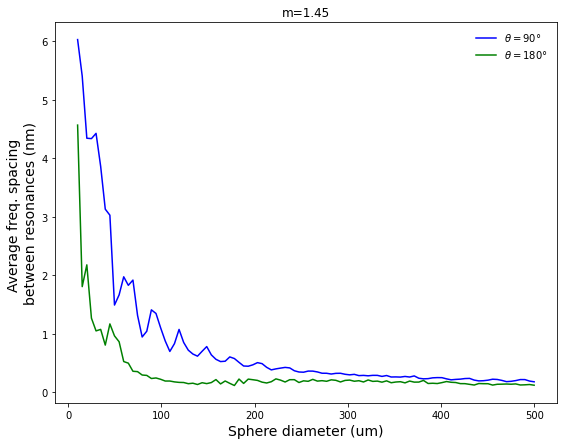

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.plot(rad*2, spec_range*1000, 'b', label=r'$\theta=90 \degree$')
ax.plot(rad*2, spec_range_180*1000, 'g', label=r'$\theta=180 \degree$')

ax.set_xlabel('Sphere diameter (um)', fontsize=14)
ax.set_ylabel('Average freq. spacing \nbetween resonances (nm)', fontsize=14)
ax.set_title(r'm=1.45')
ax.legend(frameon=False)
plt.show()

In [117]:
spec_range_sap = np.empty_like(rad, dtype=np.float64)
for i, r in enumerate(rad):
    spec = scattered_spectrum_ang(1.768, lam, r, 90)
    spec_range_sap[i] = peak_spacing(lam, spec)

In [118]:
spec_range_sap_180 = np.empty_like(rad, dtype=np.float64)
for i, r in enumerate(rad):
    spec = scattered_spectrum_ang(1.768, lam, r, 180)
    spec_range_sap_180[i] = peak_spacing(lam, spec)

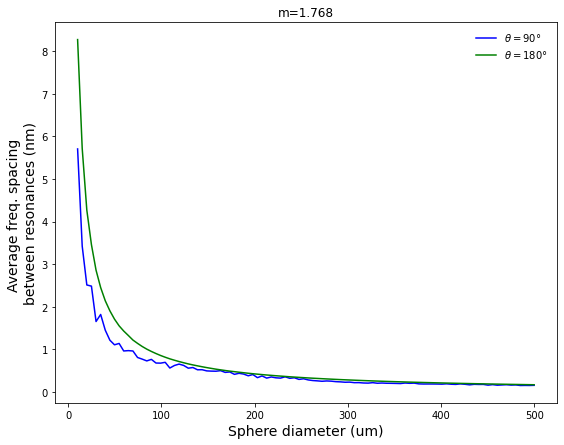

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.plot(rad*2, spec_range_sap*1000, 'b', label=r'$\theta=90 \degree$')
ax.plot(rad*2, spec_range_sap_180*1000, 'g', label=r'$\theta=180 \degree$')

ax.set_xlabel('Sphere diameter (um)', fontsize=14)
ax.set_ylabel('Average freq. spacing \nbetween resonances (nm)', fontsize=14)
ax.set_title(r'm=1.768')
ax.legend(frameon=False)
plt.show()

Find the largest sphere that can be resolved by the spectrometer (resolution ~ 1 nm).

In [124]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [134]:
print('Largest silica sphere can be resolved: ')
print(rad[find_nearest_idx(spec_range, 0.001)] * 2, 'um')

Largest silica sphere can be resolved: 
84.24242424242425 um


In [135]:
print('Largest sapphire sphere can be resolved: ')
print(rad[find_nearest_idx(spec_range_sap, 0.001)] * 2, 'um')

Largest sapphire sphere can be resolved: 
64.44444444444446 um
